___
# **Final code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## Group Members -- Avneesh Pradhan, Chethana Yerramsetty, and Ethan Hessick
## BME5710 -- Spring 2024

___
## Use the $m_1$ training images to train a CNN-based image denoiser. Since you are only given clean images, you will simulate noisy images, $\{\boldsymbol{x}^{(i)}_{\sf tr}\}_{i=1}^{m_1}$, by adding zero-mean Gaussian noise to $\{\boldsymbol{y}^{(i)}_{\sf tr}\}_{i=1}^{m_1}$. You can do so dynamically during the training process. See `starter_code.ipynb` for an example. To train the network, you will minimize a loss, e.g., mean square error, between the clean images $\{\boldsymbol{y}_{\sf tr}^{(i)}\}_{i=1}^{m_1}$ and the denoised images $\{\widehat{\boldsymbol{y}}_{\sf tr}^{(i)}\}_{i=1}^{m_1}$ 


In [1]:
# IMPORT LIBRARIES
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import tifffile 
import torch.nn.modules.loss as nnLoss

# Tex Live Settings
from fontsetting import font_cmu
plt = font_cmu(plt)

# Check GPU/CPU - can delete later
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)


/Users/ethanhessick/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ethanhessick/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/ethanhessick/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/ethanhessick/anaconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Device available: cpu


In [2]:
# LOAD IMAGES - Can copy code from above

# Loading TIFF images
class TIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            image = self.transform(image)
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Loading TIFF images
class AugmentedTIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return 2*len(self.filenames)

    def __getitem__(self, idx):
        index = int(np.floor(idx/2))
        img_path = os.path.join(self.directory, self.filenames[index])
        base_image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            if idx%2 == 0:
                image = self.transform(base_image)
            elif idx%2 == 1:
                image = torch.flip(self.transform(base_image), dims=(-1,))

        
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('train-clean-tif', transform=transform)
augmented_train_dataset = AugmentedTIFFDataset('train-clean-tif', transform=transform)


# Function to create data loader
def create_loader(train_dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility of random numbers in PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creates a training DataLoader from this Dataset
    return train_loader

m_tr = len(train_dataset)
print('Number of images in the training dataset:', m_tr)

m_tr_aug = len(augmented_train_dataset)
print('Number of images in the augmented training dataset:', m_tr_aug)

# Add in loading of validation and testing data. 

# Create the dataset for validation images
val_dataset = TIFFDataset('val-clean-tif', transform=transform)
m_val = len(val_dataset)
print('Number of images in the validation dataset:', m_val)

# Create the dataset for testing images
test_dataset = TIFFDataset('test-clean-tif', transform=transform)
m_te = len(test_dataset)
print('Number of images in the testing dataset:', m_te)


Number of images in the training dataset: 52
Number of images in the augmented training dataset: 104
Number of images in the validation dataset: 16
Number of images in the testing dataset: 16


___
## Once trained, use the $m_3$ test images to evaluate performance in terms of ${\sf{NMSE}}(\boldsymbol{y}, \widehat{\boldsymbol{y}}) = 20\log_{10} \frac{\|\boldsymbol{y} - \widehat{\boldsymbol{y}}\|_2}{\|\boldsymbol{y}\|_2}$ and structural similarity index (SSIM). You will compute NMSE using the expression provided here. For SSIM you may use a built-in function. The test images will be provided closer to the submission deadline. So, your focus should be on maximizing the performance on the validation images.


In [3]:
# DEFINE FUNCTION TO CALCULATE NMSE
def nmseCalc(actual_img, predicted_img):

    # if either image is a tensor, must convert
    # print(type(actual_img))
    if type(actual_img) == torch.Tensor:
        actual_img = actual_img.detach().numpy()
        # print(type(actual_img), actual_img.shape)
    if type(predicted_img) == torch.Tensor:
        predicted_img = predicted_img.detach().numpy()
    # use formula in description
    
    # calc l2 norm of actual (denominator)
    denominator = np.sqrt(np.sum(np.array(actual_img)**2))
    #print((np.array(actual_img))[0, 0:3, 0])
    #print((np.array(actual_img)**2)[0, 0:3, 0])
    
    # calc l2 norm of acutal - prediction (numerator)
    numerator = np.sqrt(np.sum(np.array(actual_img - predicted_img)**2))

    # 20 * log to finish it off
    nonzero = 0 # ensure not dividing by zero. 
    return 20 * np.log10(numerator/(denominator+nonzero))

# testing
#nmse_val1 = nmseCalc(val_clean, val_denoised)
#print(nmse_val1)

# loss function for NMSE

class nmseLoss(nn.Module):
    def __init__(self):
        super(nmseLoss, self).__init__()
    
    def forward(self, inputs, targets):
        loss = torch.linalg.norm(targets - inputs) / torch.linalg.norm(targets)
        loss = 20 * torch.log10(loss)
        return loss.mean()
        
    

"""class nmseLoss(nnLoss._Loss):
    Creates a criterion that measures the opposite NMSE (so its positive)
      
    
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)

    def forward(self, input: nnLoss.Tensor, target: nnLoss.Tensor) -> nnLoss.Tensor:
        batch_size = target.size()[0]

        nmseVals = nnLoss.Tensor(input.size())
        for i in range(0, batch_size):
            nmseVals[i] -= nmseCalc(target[i], input[i])

        return nmseVals"""

# Using SSIM function from skimage library
from skimage.metrics import structural_similarity as ssim

# wrap into function for each of use
def ssimCalc(img_1, img_2):
    """ Input img_1 and img_2 as tensors of [1 x m x n] size. """

        # if either image is a tensor, must convert
    if type(img_1) == torch.Tensor:
        img_1 = img_1.detach().numpy()
    if type(img_2) == torch.Tensor:
        img_2 = img_2.detach().numpy()

    # remove extra index
    img_1 = img_1[0]
    img_2 = img_2[0]

    # use data range of 1.0 because values can be from 0 to 1 in this application
    return ssim(img_1, img_2, data_range=1.0)

#ssim_val1 = ssimCalc(val_clean, val_denoised)
#print(ssim_val1)

___
## Section for Building Different CNNs and versions of them.


In [4]:
# Trivial CNN from Dr Ahmad

class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [5]:
# UNET Class - Fixing to actually be UNet
class UNetAct(nn.Module):
    def __init__(self, dropout=0.5, layer_factor=64, act = nn.ReLU(), last_act=None, kernel=3):
        super(UNetAct, self).__init__()
        self.act = act
        self.last_act = last_act
        self.dropout = dropout
        self.layer_factor= layer_factor
        self.kernel = (kernel, kernel)
        pad = np.floor((kernel - 1) / 2)
        self.padding = (int(pad), int(pad))
        num_ch1 = int(self.layer_factor) # 64
        num_ch2 = num_ch1 * 2 # 128
        num_ch3 = num_ch2 * 2 # 256
        num_ch4 = num_ch3 * 2 # 512
        num_ch5 = num_ch4 * 2 # 1024

        # print(self.kernel, self.padding)


        # Condensing - first layer go from 1 - 64 channels and maintain pixel size
        self.conv1a = nn.Conv2d(in_channels=1, out_channels=num_ch1, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.conv1b = nn.Conv2d(in_channels=num_ch1, out_channels=num_ch1, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.dropout1 = nn.Dropout(p=self.dropout/2)

        # second layer: 64-128 channels and decrease number of pixels
        self.conv2a = nn.Conv2d(in_channels=num_ch1, out_channels=num_ch2, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.conv2b = nn.Conv2d(in_channels=num_ch2, out_channels=num_ch2, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.dropout2 = nn.Dropout(p=self.dropout)

        # third layer: 128 - 256 channels and decreased number of pixels
        self.conv3a = nn.Conv2d(in_channels=num_ch2, out_channels=num_ch3, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.conv3b = nn.Conv2d(in_channels=num_ch3, out_channels=num_ch3, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.dropout3 = nn.Dropout(p=self.dropout)

        # fourth layer: 256 - 512 channels and decreased number of pixels
        self.conv4a = nn.Conv2d(in_channels=num_ch3, out_channels=num_ch4, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.conv4b = nn.Conv2d(in_channels=num_ch4, out_channels=num_ch4, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.pool4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.dropout4 = nn.Dropout(p=self.dropout)

        # Middle - double channels (512 to 1024) keep size
        self.convm1 = nn.Conv2d(in_channels=num_ch4, out_channels=num_ch5, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.convm2 = nn.Conv2d(in_channels=num_ch5, out_channels=num_ch5, kernel_size=self.kernel, padding=self.padding, stride=(1,1))   

        # Reexpanding fourth layer: double pixel size and decrease from 1024 - 512 channels
        self.deconv4 = nn.ConvTranspose2d(in_channels=num_ch5, out_channels=num_ch4, kernel_size=(2,2), padding=0, stride=(2,2))
        self.udropout4 = nn.Dropout(p=self.dropout)
        self.uconv4a = nn.Conv2d(in_channels=num_ch5, out_channels=num_ch4, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.uconv4b = nn.Conv2d(in_channels=num_ch4, out_channels=num_ch4, kernel_size=self.kernel, padding=self.padding, stride=(1,1))

        # third layer: double pixel number and decrease from 512 - 256 channels
        self.deconv3 = nn.ConvTranspose2d(in_channels=num_ch4, out_channels=num_ch3, kernel_size=(2,2), padding=0, stride=(2,2))
        self.udropout3 = nn.Dropout(p=self.dropout)
        self.uconv3a = nn.Conv2d(in_channels=num_ch4, out_channels=num_ch3, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.uconv3b = nn.Conv2d(in_channels=num_ch3, out_channels=num_ch3, kernel_size=self.kernel, padding=self.padding, stride=(1,1))

        # second layer: double number of pixels and decrease from 256 to 128 channels
        self.deconv2 = nn.ConvTranspose2d(in_channels=num_ch3, out_channels=num_ch2, kernel_size=(2,2), padding=0, stride=(2,2))
        self.udropout2 = nn.Dropout(p=self.dropout)
        self.uconv2a = nn.Conv2d(in_channels=num_ch3, out_channels=num_ch2, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.uconv2b = nn.Conv2d(in_channels=num_ch2, out_channels=num_ch2, kernel_size=self.kernel, padding=self.padding, stride=(1,1))

        # first layer: double number of pixels and decrease from 128 to 64 channels
        self.deconv1 = nn.ConvTranspose2d(in_channels=num_ch2, out_channels=num_ch1, kernel_size=(2,2), padding=0, stride=(2,2))
        self.udropout1 = nn.Dropout(p=self.dropout)
        self.uconv1a = nn.Conv2d(in_channels=num_ch2, out_channels=num_ch1, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        self.uconv1b = nn.Conv2d(in_channels=num_ch1, out_channels=num_ch1, kernel_size=self.kernel, padding=self.padding, stride=(1,1))
        
        # double number of pixels to get back to original size
        self.deconv0 = nn.ConvTranspose2d(in_channels=num_ch1, out_channels=num_ch1, kernel_size=(2,2), padding=0, stride=(2,2))

        # condense into one channel
        self.output_layer = nn.Conv2d(in_channels=num_ch1, out_channels=1, kernel_size=(1,1), padding=0, stride=(1,1))

    def forward(self, x):

        # first condensing step layers (encoding block)
        #print("Input", x.shape)
        x = self.dropout1(self.act(self.conv1b(self.act(self.conv1a(x))))) # first condensing
        conv1 = x
        x = self.pool1(x)

        #print("1st pooling", x.shape)
        x = self.dropout2(self.act(self.conv2b(self.act(self.conv2a(x))))) # second condensing
        conv2 = x
        x = self.pool2(x)

        #print("2nd pooling", x.shape)
        x = self.dropout3(self.act(self.conv3b(self.act(self.conv3a(x))))) # third condensing
        conv3 = x
        x = self.pool3(x)

        #print("3rd pooling", x.shape)
        x = self.dropout4(self.act(self.conv4b(self.act(self.conv4a(x))))) # fourth condensing
        conv4 = x
        x = self.pool4(x)

        #print("4th pooling", x.shape)

        # middle layer
        x = self.act(self.convm2(self.act(self.convm1(x))))
        #print("after middle", x.shape)
        #print("1st concatenate", self.deconv4(x).shape, ' + ', conv4.shape)

        # decoding block
        x = torch.cat((self.deconv4(x), conv4), dim=-3) # fourth layer skip connection
        #print("first concatenation:", x.shape)
        x = self.act(self.uconv4b(self.act(self.uconv4a(self.udropout4(x))))) # fourth layer decoding
        #print("after 1st back up", x.shape)
        #print("2nd concatenate", self.deconv3(x).shape, ' + ', conv3.shape)


        x = torch.cat((self.deconv3(x), conv3), dim=-3) # 3rd layer skip connection
        x = self.act(self.uconv3b(self.act(self.uconv3a(self.udropout3(x))))) # 3rd layer decoding
        #print("after 2nd back up", x.shape)
        #print("3rd concatenate", self.deconv2(x).shape, ' + ', conv2.shape)

        x = torch.cat((self.deconv2(x), conv2), dim=-3) # 2nd layer skip connection
        x = self.act(self.uconv2b(self.act(self.uconv2a(self.udropout2(x))))) # 2nd layer decoding
        #print("after 3rd back up", x.shape)
        #print("4th concatenate", self.deconv1(x).shape, ' + ', conv1.shape)

        x = torch.cat((self.deconv1(x), conv1), dim=-3) # 1st layer skip connection
        x = self.act(self.uconv1b(self.act(self.uconv1a(self.udropout1(x))))) # 1st layer decoding
        #print("after 4th back up", x.shape)
        
        x = self.output_layer(x) # condense into output channel
        if self.last_act:
            x = self.last_act(x)
        #print("Output", x.shape)
    
        return x

#input_layer = Input((img_size_target, img_size_target, 1))
#output_layer = build_model(input_layer, 16)

___
## Model Training Function. Modified to show plot (and return data) for loss, NMSE, and SSIM for each epoch (training and validation). 

In [6]:
# TRAINING FUNCTION FOR CLASS 
# Look into modifying Loss function, and/or adding Dropout
def train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epoch, noise_std, plot=True, printing=True):

    avg_train_losses = np.zeros([num_epoch]) # training loss
    avg_train_nmse = np.zeros([num_epoch]) # training NMSE
    avg_train_ssim = np.zeros([num_epoch]) # training SSIM
    avg_val_losses = np.zeros([num_epoch]) # validation loss
    avg_val_nmse = np.zeros([num_epoch]) # validation NMSE
    avg_val_ssim = np.zeros([num_epoch]) # validation SSIM

    for epoch in range(num_epoch): # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0
        total_train_nmse = 0
        total_train_ssim = 0
        for i, y_tr_batch in enumerate(train_loader): # Loop over mini-batches
            noise = torch.randn_like(y_tr_batch) * noise_std # ZERO MEAN GAUSSIAN NOISE WITH STD = noise_std (0.1)
            x_tr_batch = y_tr_batch + noise

            opt.zero_grad() # delete previous gradients
            y_hat_tr_batch = model(x_tr_batch) # forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch) # compute loss
            loss.backward() # backward pass
            opt.step() # update weights
            total_train_loss += loss.item() # accumulate loss
            for image in range(0, y_tr_batch.shape[-4]):
                total_train_nmse += nmseCalc(y_tr_batch[image], y_hat_tr_batch[image]) / y_tr_batch.shape[-4]
                total_train_ssim += ssimCalc(y_tr_batch[image], y_hat_tr_batch[image]) / y_tr_batch.shape[-4]

        avg_train_losses[epoch] = total_train_loss / len(train_loader) # compute average loss, add to storage
        avg_train_nmse[epoch] = total_train_nmse / len(train_loader) # compute average nmse, add to storage
        avg_train_ssim[epoch] = total_train_ssim / len(train_loader) # compute average ssim, add to storage

        # calculate values for validation set data
        model.eval()
        total_val_loss = 0
        total_val_nmse = 0
        total_val_ssim = 0

        for image in val_dataset:   # cycle through each image  
            # create noisy image and apply model to it
            val_noisy = image + (torch.randn_like(image) * noise_std) # apply noise
            val_denoised = model(val_noisy).detach() # Denoise the noisy image using the trained model

            # calculate loss and other metrics
            total_val_loss += criterion(val_denoised, image)
            total_val_nmse += nmseCalc(image, val_denoised) # use user defined nmse calculation
            total_val_ssim += ssimCalc(image, val_denoised) 
        
        avg_val_losses[epoch] = total_val_loss / len(val_dataset) # compute average loss, add to storage
        avg_val_nmse[epoch] = total_val_nmse / len(val_dataset) # compute average nmse, add to storage
        avg_val_ssim[epoch] = total_val_ssim / len(val_dataset) # compute average ssim, add to storage


        if type(lr_scheduler) == type(optim.lr_scheduler.ReduceLROnPlateau(opt)): # if using ReduceLROnPlateau scheduler! 
            lr_scheduler.step(avg_val_nmse[epoch]) # learning rate scheduler
        elif lr_scheduler: # if using any other learning_rate scheduler
            lr_scheduler.step() # learning rate scheduler

        if printing:
            print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}, NMSE: {total_train_nmse / (i+1):.6f}, SSIM: {total_train_ssim / (i+1):.6f}')
        elif epoch == num_epoch:
            print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}, NMSE: {total_train_nmse / (i+1):.6f}, SSIM: {total_train_ssim / (i+1):.6f}')



    # Plotting Loss Over Epochs
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(12, 7))
        ax[0].plot(range(1, num_epoch+1), avg_train_losses, label='training loss')
        ax[0].plot(range(1, num_epoch+1), avg_val_losses, label='validation loss')
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel(criterion)
        ax[0].set_title('Loss over Epochs')
        ax[0].grid(True)
        ax[0].legend()

        # Plotting NMS over epochs
        ax[1].plot(range(1, num_epoch+1), avg_train_nmse, label='training NMSE')
        ax[1].plot(range(1, num_epoch+1), avg_val_nmse, label='validation NMSE')
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('Average NMSE')  
        ax[1].set_title('NMSE over Epochs')
        ax[1].grid(True)
        ax[1].legend()

        ax[2].plot(range(1, num_epoch+1), avg_train_ssim, label='training SSIM')
        ax[2].plot(range(1, num_epoch+1), avg_val_ssim, label='validation SSIM')
        ax[2].set_xlabel('epochs')
        ax[2].set_ylabel('Average SSIM')
        ax[2].set_title('SSIM over Epochs')
        ax[2].grid(True)
        ax[2].legend()

        plt.tight_layout()
        plt.show()

    # return data that could be useful! 
    return avg_train_losses, avg_val_losses, avg_train_nmse, avg_val_nmse, avg_train_ssim, avg_val_ssim 

___
## Use the $m_2$ validation images to fine tune your network. Don't use these images to train the network. Again, to create clean-noisy image pairs, add noise to $\{\boldsymbol{y}^{(i)}_{\sf val}\}_{i=1}^{m_2}$ go simulate $\{\boldsymbol{x}^{(i)}_{\sf val}\}_{i=1}^{m_2}$


In [7]:
# Set initial values for Hyperparameters 
batch_size = 4  # Number of complete images in each batch
lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
num_epoch = 15  # Epochs
dropout = 0
layer_factor = 4
kernel = 3
criterion = nmseLoss() # Pick a loss function
act = nn.ReLU()
last_act = None
train_loader = create_loader(augmented_train_dataset, batch_size)

# create function to fetch lr_scheduler
def fetch_lr_scheduler(opt, lr_i=None):
    if lr_i == 0:
        return optim.lr_scheduler.LinearLR(opt)
    elif lr_i == 1:
        return optim.lr_scheduler.ReduceLROnPlateau(opt)
    
    else: # if none given, return list (only will happen in first part)
        return [optim.lr_scheduler.LinearLR(opt), optim.lr_scheduler.ReduceLROnPlateau(opt)]  # Number of complete images in each batch

lr_i = 0


In [8]:
# Testing Different Loss Functions
criterion = nmseLoss()
best_loss_function = criterion
print(f"{criterion} won best Loss Function. See results in 'optimizing_hypereparametes.ipynb'")

"""
train_loader = create_loader(train_dataset, batch_size) 

# Create plot to plot each value
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

loss_funcs = [nmseLoss(), nn.MSELoss(), nn.HuberLoss()]
train_val_nmse = np.zeros([len(loss_funcs), num_epoch])

for i in range(0, len(loss_funcs)): # for loop to go through batch sizes

    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernel) # Pick a model
    opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
    lr_scheduler = fetch_lr_scheduler(opt, lr_i)

    print(f"Loss Function: {loss_funcs[i]}")
    storage = train_model(model, opt, lr_scheduler, loss_funcs[i], train_loader, val_dataset, num_epoch, noise_std=sig, plot=False)
    train_val_nmse[i, :] = storage[3]

    ax[0].plot(range(1, num_epoch+1), storage[2], label=loss_funcs[i])
    ax[1].plot(range(1, num_epoch+1), train_val_nmse[i, :], label=loss_funcs[i])
    ax[2].plot(range(1, num_epoch+1), storage[0], label=loss_funcs[i])

#format plot
for i in range(0,3):
    ax[i].set_xlabel('epochs')
    ax[i].grid(True)
   
ax[0].legend()
ax[0].set_ylabel('Training NMSE') 
ax[0].set_title('Training NMSE')
ax[1].set_ylabel('Validation NMSE') 
ax[1].set_title('Validation NMSE')
ax[2].set_ylabel('Training Loss') 
ax[2].set_title('Training Loss')

plt.tight_layout()
plt.show()

# find and choose best model
best_i = np.argmin(np.array(train_val_nmse[:, -1]))
best_loss_function = loss_funcs[best_i]
criterion = best_loss_function
print(f"{best_loss_function} wins best Loss Function with a validation NMSE of {train_val_nmse[best_i, -1]} after {num_epoch} epochs.")"""

nmseLoss() won best Loss Function. See results in 'optimizing_hypereparametes.ipynb'


'\ntrain_loader = create_loader(train_dataset, batch_size) \n\n# Create plot to plot each value\nfig, ax = plt.subplots(1, 3, figsize=(12, 7))\n\nloss_funcs = [nmseLoss(), nn.MSELoss(), nn.HuberLoss()]\ntrain_val_nmse = np.zeros([len(loss_funcs), num_epoch])\n\nfor i in range(0, len(loss_funcs)): # for loop to go through batch sizes\n\n    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernel) # Pick a model\n    opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer\n    lr_scheduler = fetch_lr_scheduler(opt, lr_i)\n\n    print(f"Loss Function: {loss_funcs[i]}")\n    storage = train_model(model, opt, lr_scheduler, loss_funcs[i], train_loader, val_dataset, num_epoch, noise_std=sig, plot=False)\n    train_val_nmse[i, :] = storage[3]\n\n    ax[0].plot(range(1, num_epoch+1), storage[2], label=loss_funcs[i])\n    ax[1].plot(range(1, num_epoch+1), train_val_nmse[i, :], label=loss_funcs[i])\n    ax[2].plot(range(1, num_epoch+1), storag

ReLU()


Epoch 1, Iteration 26, Loss: -4.679016, NMSE: -3.784742, SSIM: 0.301974
Epoch 2, Iteration 26, Loss: -5.952510, NMSE: -4.404789, SSIM: 0.339363
Epoch 3, Iteration 26, Loss: -10.822276, NMSE: -7.720303, SSIM: 0.511750
Epoch 4, Iteration 26, Loss: -13.876506, NMSE: -11.584748, SSIM: 0.610323
Epoch 5, Iteration 26, Loss: -15.662333, NMSE: -14.764995, SSIM: 0.703300
Epoch 6, Iteration 26, Loss: -16.492809, NMSE: -16.087593, SSIM: 0.751149
Epoch 7, Iteration 26, Loss: -16.794098, NMSE: -16.449443, SSIM: 0.755231
Epoch 8, Iteration 26, Loss: -16.900600, NMSE: -16.660612, SSIM: 0.754593
Epoch 9, Iteration 26, Loss: -16.670952, NMSE: -16.747220, SSIM: 0.753488
Epoch 10, Iteration 26, Loss: -17.488918, NMSE: -16.824344, SSIM: 0.755282
Epoch 11, Iteration 26, Loss: -16.916349, NMSE: -16.871305, SSIM: 0.757636
Epoch 12, Iteration 26, Loss: -16.704184, NMSE: -16.930571, SSIM: 0.761162
Epoch 13, Iteration 26, Loss: -16.826157, NMSE: -16.962790, SSIM: 0.765972
Epoch 14, Iteration 26, Loss: -17.12586

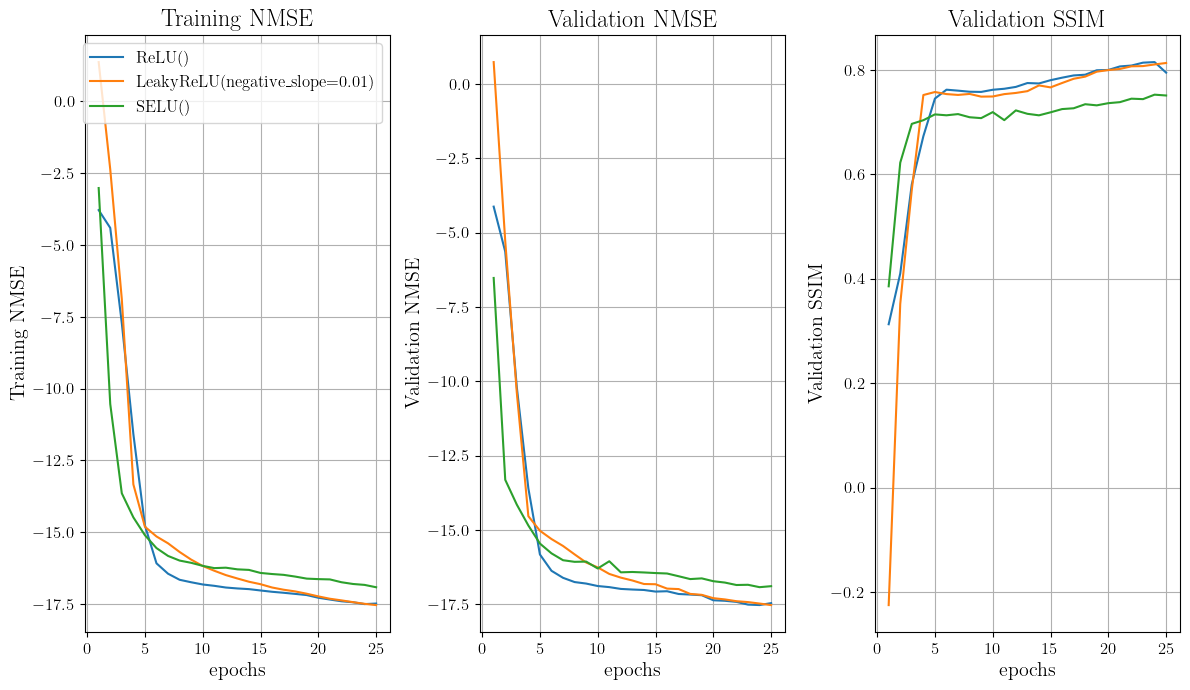

LeakyReLU(negative_slope=0.01) wins with a validation NMSE of -17.528777738094334 after 25 epochs.


In [9]:
# Testing Different Activation Functions
lr = 1e-3
num_epoch = 25 # want a little deeper training here

activations = [nn.ReLU(), nn.LeakyReLU(), nn.SELU()]
train_val_nmse = np.zeros([len(activations), num_epoch])

# Create plot to plot each value
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

for i in range(0, len(activations)):
    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=activations[i], last_act=last_act, kernel=kernel) # Pick a model
    opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
    print(activations[i])
    lr_scheduler = fetch_lr_scheduler(opt, lr_i)

    storage = train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epoch, noise_std=sig, plot=False)
    train_val_nmse[i, :] = storage[3]
    ax[0].plot(range(1, num_epoch+1), storage[2], label=activations[i])
    ax[1].plot(range(1, num_epoch+1), train_val_nmse[i, :], label=activations[i])
    ax[2].plot(range(1, num_epoch+1), storage[5], label=activations[i])

#format plot
for i in range(0,3):
    ax[i].set_xlabel('epochs')
    ax[i].grid(True)
   
ax[0].legend()
ax[0].set_ylabel('Training NMSE') 
ax[0].set_title('Training NMSE')
ax[1].set_ylabel('Validation NMSE') 
ax[1].set_title('Validation NMSE')
ax[2].set_ylabel('Validation SSIM') 
ax[2].set_title('Validation SSIM')

plt.tight_layout()
plt.show()

# find and choose best model
best_i = np.argmin(np.array(train_val_nmse[:, -1]))
best_act = activations[best_i] # save best activation function to use later! 
act = best_act
print(f"{best_act} wins with a validation NMSE of {train_val_nmse[best_i, -1]} after {num_epoch} epochs.")


Last Layer Activation: None
Epoch 1, Iteration 26, Loss: -2.136026, NMSE: 1.489393, SSIM: 0.235001
Epoch 2, Iteration 26, Loss: -3.414234, NMSE: -2.747564, SSIM: 0.215184
Epoch 3, Iteration 26, Loss: -5.961230, NMSE: -4.527881, SSIM: 0.344161
Epoch 4, Iteration 26, Loss: -10.088392, NMSE: -7.799850, SSIM: 0.488751
Epoch 5, Iteration 26, Loss: -12.472354, NMSE: -11.375142, SSIM: 0.587107
Epoch 6, Iteration 26, Loss: -13.596851, NMSE: -13.171616, SSIM: 0.659437
Epoch 7, Iteration 26, Loss: -13.827048, NMSE: -13.957253, SSIM: 0.677760
Epoch 8, Iteration 26, Loss: -15.226360, NMSE: -14.565511, SSIM: 0.691917
Epoch 9, Iteration 26, Loss: -15.918851, NMSE: -15.295078, SSIM: 0.710095
Epoch 10, Iteration 26, Loss: -16.449682, NMSE: -15.721576, SSIM: 0.719924
Epoch 11, Iteration 26, Loss: -16.222380, NMSE: -15.994499, SSIM: 0.733251
Epoch 12, Iteration 26, Loss: -15.872502, NMSE: -16.176843, SSIM: 0.740300
Epoch 13, Iteration 26, Loss: -15.733013, NMSE: -16.300411, SSIM: 0.745817
Epoch 14, Iter

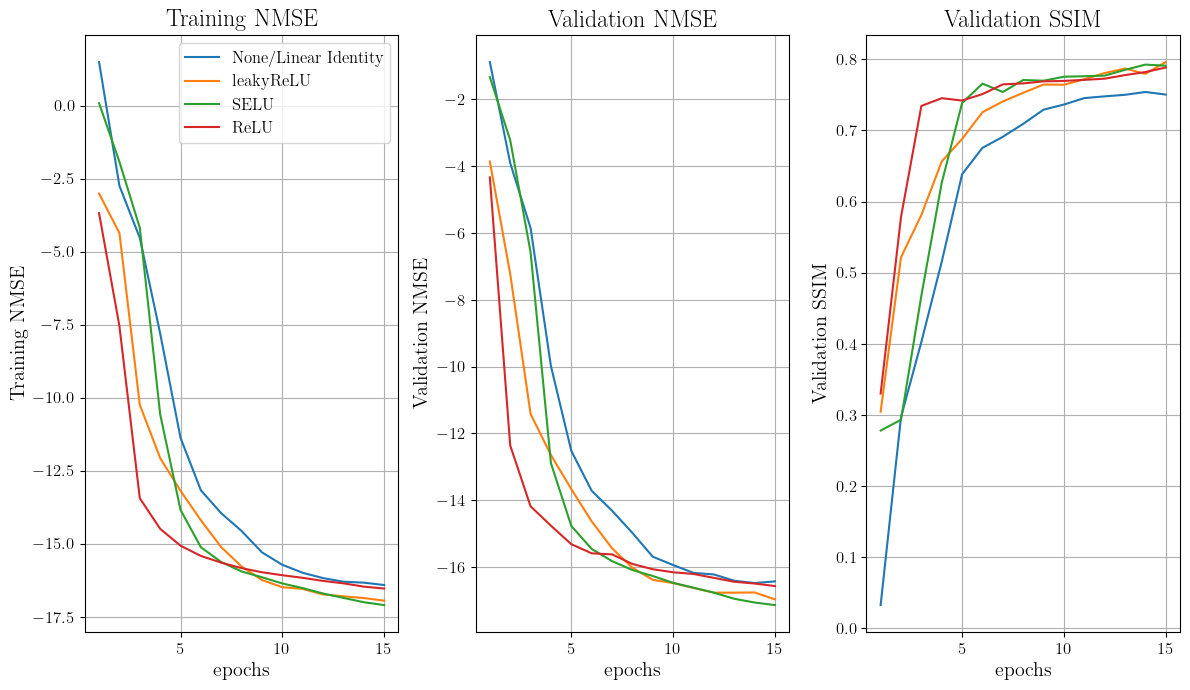

SELU() wins best Last Layer Activation Function with a validation NMSE of -17.137474823329956 after 15 epochs.


In [11]:
# Testing Different Last Layer Activation Functions
num_epoch = 15 # dont need as deep here

last_layer_activations = [None, nn.LeakyReLU(), nn.SELU(), nn.ReLU()] # None is linear
last_layer_labels = ["None/Linear Identity", "leakyReLU", "SELU", "ReLU"]
train_val_nmse = np.zeros([len(last_layer_activations), num_epoch])


# Create plot to plot each value
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

for i in range(0, len(last_layer_activations)):
    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_layer_activations[i], kernel=kernel) # Pick a model
    opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
    print(f"Last Layer Activation: {last_layer_activations[i]}")
    storage = train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epoch, noise_std=sig, plot=False)
    train_val_nmse[i, :] = storage[3]

    ax[0].plot(range(1, num_epoch+1), storage[2], label=last_layer_labels[i])
    ax[1].plot(range(1, num_epoch+1), train_val_nmse[i, :], label=last_layer_labels[i])
    ax[2].plot(range(1, num_epoch+1), storage[5], label=last_layer_labels[i])

#format plot
for i in range(0,3):
    ax[i].set_xlabel('epochs')
    ax[i].grid(True)
   
ax[0].legend()
ax[0].set_ylabel('Training NMSE') 
ax[0].set_title('Training NMSE')
ax[1].set_ylabel('Validation NMSE') 
ax[1].set_title('Validation NMSE')
ax[2].set_ylabel('Validation SSIM') 
ax[2].set_title('Validation SSIM')

plt.tight_layout()
plt.show()

# find and choose best model
best_i = np.argmin(np.array(train_val_nmse[:, -1]))
best_last_act = last_layer_activations[best_i]
last_act = best_last_act
print(f"{best_last_act} wins best Last Layer Activation Function with a validation NMSE of {train_val_nmse[best_i, -1]} after {num_epoch} epochs.")


LR Scheduler: <torch.optim.lr_scheduler.LinearLR object at 0x133619f50>
Epoch 1, Iteration 26, Loss: 9.820797, NMSE: 10.234820, SSIM: -0.206760
Epoch 2, Iteration 26, Loss: 8.932424, NMSE: 9.702977, SSIM: -0.217560
Epoch 3, Iteration 26, Loss: 3.814626, NMSE: 7.861085, SSIM: -0.218119
Epoch 4, Iteration 26, Loss: -3.795461, NMSE: -3.235777, SSIM: 0.113007
Epoch 5, Iteration 26, Loss: -4.648931, NMSE: -4.264042, SSIM: 0.218043
Epoch 6, Iteration 26, Loss: -4.314497, NMSE: -4.375637, SSIM: 0.263208
Epoch 7, Iteration 26, Loss: -4.288766, NMSE: -4.476041, SSIM: 0.285156
Epoch 8, Iteration 26, Loss: -4.491082, NMSE: -4.467893, SSIM: 0.297593
Epoch 9, Iteration 26, Loss: -3.736621, NMSE: -4.554151, SSIM: 0.306653
Epoch 10, Iteration 26, Loss: -4.286518, NMSE: -4.617474, SSIM: 0.311703
Epoch 11, Iteration 26, Loss: -3.935112, NMSE: -4.591275, SSIM: 0.318167
Epoch 12, Iteration 26, Loss: -5.116759, NMSE: -4.688589, SSIM: 0.322006
Epoch 13, Iteration 26, Loss: -4.975120, NMSE: -4.760177, SSIM:

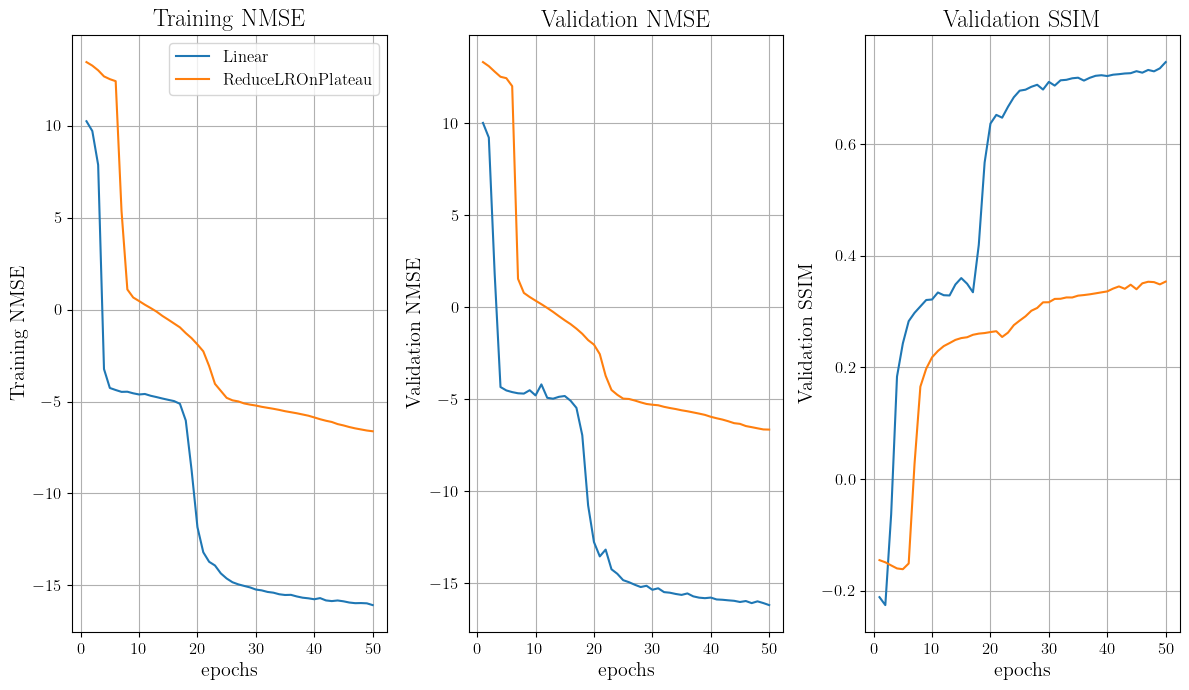

Linear wins best Learning Rate Scheduler with a validation NMSE of -16.18833767804246 after 50 epochs.


In [12]:
# Testing Different Learning Rate Schedulers
train_loader = create_loader(augmented_train_dataset, batch_size) 

# Create plot to plot each value
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

# need deep
layer_factor = 2
num_epoch = 50
lr = 1e-3
    
lr_labels = ["Linear", "ReduceLROnPlateau"]
train_val_nmse = np.zeros([len(lr_labels), num_epoch])

for i in range(0, len(lr_labels)): # for loop to go through batch sizes

    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernel) # Pick a model
    opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
    lr_schedulers = fetch_lr_scheduler(opt)
    
    print(f"LR Scheduler: {lr_schedulers[i]}")
    storage = train_model(model, opt, lr_schedulers[i], criterion, train_loader, val_dataset, num_epoch, noise_std=sig, plot=False)
    train_val_nmse[i, :] = storage[3]

    ax[0].plot(range(1, num_epoch+1), storage[2], label=lr_labels[i])
    ax[1].plot(range(1, num_epoch+1), train_val_nmse[i, :], label=lr_labels[i])
    ax[2].plot(range(1, num_epoch+1), storage[5], label=lr_labels[i])

#format plot
for i in range(0,3):
    ax[i].set_xlabel('epochs')
    ax[i].grid(True)
   
ax[0].legend()
ax[0].set_ylabel('Training NMSE') 
ax[0].set_title('Training NMSE')
ax[1].set_ylabel('Validation NMSE') 
ax[1].set_title('Validation NMSE')
ax[2].set_ylabel('Validation SSIM') 
ax[2].set_title('Validation SSIM')

plt.tight_layout()
plt.show()

# find and choose best model
best_lr_i = np.argmin(np.array(train_val_nmse[:, -1]))
best_lr_scheduler = lr_labels[best_lr_i]
lr_i = best_lr_i
print(f"{best_lr_scheduler} wins best Learning Rate Scheduler with a validation NMSE of {train_val_nmse[best_lr_i, -1]} after {num_epoch} epochs.")

In [13]:
# Testing Learning Rate
lr = 1e-3
best_lr = 1e-3
print(f"{best_lr} won best learning rate. See results in 'optimizing_hypereparametes.ipynb'")

"""
# need deep
layer_factor = 2
num_epoch = 50

learning_rates = [1e-4, 1e-3, 1e-2, 5e-2]
train_val_nmse = np.zeros([len(learning_rates), num_epoch])

# Create plot to plot each value
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

for i in range(0, len(learning_rates)):
    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernel) # Pick a model
    opt = optim.Adam(model.parameters(), lr=learning_rates[i]) # Pick an optimizer
    print(f"Learning Rate: {learning_rates[i]}")
    lr_scheduler = fetch_lr_scheduler(opt, lr_i)
    storage = train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epoch, noise_std=sig, plot=False)
    train_val_nmse[i, :] = storage[3]
    ax[0].plot(range(1, num_epoch+1), storage[2], label=learning_rates[i])
    ax[1].plot(range(1, num_epoch+1), train_val_nmse[i, :], label=learning_rates[i])
    ax[2].plot(range(1, num_epoch+1), storage[5], label=learning_rates[i])

#format plot
for i in range(0,3):
    ax[i].set_xlabel('epochs')
    ax[i].grid(True)
   
ax[0].legend()
ax[0].set_ylabel('Training NMSE') 
ax[0].set_title('Training NMSE')
ax[1].set_ylabel('Validation NMSE') 
ax[1].set_title('Validation NMSE')
ax[2].set_ylabel('Validation SSIM') 
ax[2].set_title('Validation SSIM')

plt.tight_layout()
plt.show()

# find and choose best model
best_i = np.argmin(np.array(train_val_nmse[:, -1]))
best_lr = learning_rates[best_i] # save best activation function to use later! 
lr = best_lr
print(f"{best_lr} wins with a validation NMSE of {train_val_nmse[best_i, -1]} after {num_epoch} epochs.")
"""

0.001 won best learning rate. See results in 'optimizing_hypereparametes.ipynb'


'\n# need deep\nlayer_factor = 2\nnum_epoch = 50\n\nlearning_rates = [1e-4, 1e-3, 1e-2, 5e-2]\ntrain_val_nmse = np.zeros([len(learning_rates), num_epoch])\n\n# Create plot to plot each value\nfig, ax = plt.subplots(1, 3, figsize=(12, 7))\n\nfor i in range(0, len(learning_rates)):\n    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernel) # Pick a model\n    opt = optim.Adam(model.parameters(), lr=learning_rates[i]) # Pick an optimizer\n    print(f"Learning Rate: {learning_rates[i]}")\n    lr_scheduler = fetch_lr_scheduler(opt, lr_i)\n    storage = train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epoch, noise_std=sig, plot=False)\n    train_val_nmse[i, :] = storage[3]\n    ax[0].plot(range(1, num_epoch+1), storage[2], label=learning_rates[i])\n    ax[1].plot(range(1, num_epoch+1), train_val_nmse[i, :], label=learning_rates[i])\n    ax[2].plot(range(1, num_epoch+1), storage[5], label=learning_rates[i])\n\n#fo

Dropout Rate: 0
Epoch 1, Iteration 26, Loss: 0.692942, NMSE: -0.865135, SSIM: 0.273134
Epoch 2, Iteration 26, Loss: -4.188683, NMSE: -2.744792, SSIM: 0.284859
Epoch 3, Iteration 26, Loss: -4.528973, NMSE: -4.008927, SSIM: 0.317035
Epoch 4, Iteration 26, Loss: -8.914747, NMSE: -6.025212, SSIM: 0.409703
Epoch 5, Iteration 26, Loss: -11.087992, NMSE: -9.660967, SSIM: 0.567582
Epoch 6, Iteration 26, Loss: -11.260119, NMSE: -10.788306, SSIM: 0.628070
Epoch 7, Iteration 26, Loss: -11.349831, NMSE: -11.415216, SSIM: 0.647885
Epoch 8, Iteration 26, Loss: -12.572144, NMSE: -12.083522, SSIM: 0.665652
Epoch 9, Iteration 26, Loss: -13.354916, NMSE: -13.006566, SSIM: 0.683577
Epoch 10, Iteration 26, Loss: -14.202013, NMSE: -13.689087, SSIM: 0.694356
Epoch 11, Iteration 26, Loss: -14.129342, NMSE: -14.137235, SSIM: 0.699427
Epoch 12, Iteration 26, Loss: -15.157612, NMSE: -14.519271, SSIM: 0.711385
Epoch 13, Iteration 26, Loss: -15.199593, NMSE: -14.793159, SSIM: 0.720196
Epoch 14, Iteration 26, Loss

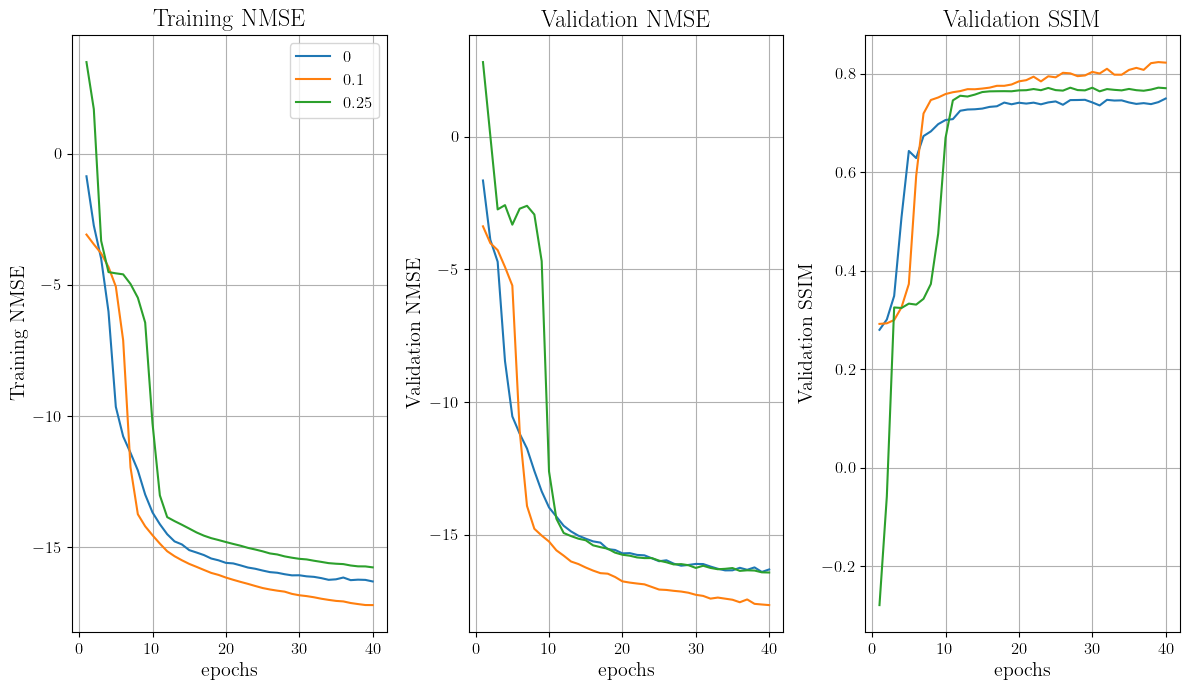

0.1 wins best Dropout Rate with a validation NMSE of -17.655367593573207 after 40 epochs.


In [15]:
# Testing Dropout Rate

dropouts = [0, 0.1, 0.25]
train_val_nmse = np.zeros([len(dropouts), num_epoch])

# need enough channels and deep for decent dropout
layer_factor = 4
num_epoch = 40

# Create plot to plot each value
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

for i in range(0, len(dropouts)):
    model = UNetAct(dropout=dropouts[i], layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernel) # Pick a model
    opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
    print(f"Dropout Rate: {dropouts[i]}")
    lr_scheduler = fetch_lr_scheduler(opt, lr_i)
    storage = train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epoch, noise_std=sig, plot=False)
    train_val_nmse[i, :] = storage[3]
    ax[0].plot(range(1, num_epoch+1), storage[2], label=dropouts[i])
    ax[1].plot(range(1, num_epoch+1), train_val_nmse[i, :], label=dropouts[i])
    ax[2].plot(range(1, num_epoch+1), storage[5], label=dropouts[i])

#format plot
for i in range(0,3):
    ax[i].set_xlabel('epochs')
    ax[i].grid(True)
   
ax[0].legend()
ax[0].set_ylabel('Training NMSE') 
ax[0].set_title('Training NMSE')
ax[1].set_ylabel('Validation NMSE') 
ax[1].set_title('Validation NMSE')
ax[2].set_ylabel('Validation SSIM') 
ax[2].set_title('Validation SSIM')

plt.tight_layout()
plt.show()

# find and choose best model
best_i = np.argmin(np.array(train_val_nmse[:, -1]))
best_dropout = dropouts[best_i] # save best activation function to use later! 
dropout = best_dropout
print(f"{best_dropout} wins best Dropout Rate with a validation NMSE of {train_val_nmse[best_i, -1]} after {num_epoch} epochs.")


In [16]:
# Testing Kernel Size
kernel = 3
best_kernel = 3
print(f"({best_kernel}, {best_kernel}) won best kernel Size. See results in 'optimizing_hypereparametes.ipynb'")

"""
# want closer to normal network, medium depth
layer_factor = 6
num_epoch = 25

kernels = [1, 3, 5, 7]
train_val_nmse = np.zeros([len(kernels), num_epoch])

# Create plot to plot each value
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

for i in range(0, len(kernels)):
    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernels[i]) # Pick a model
    opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
    lr_scheduler = fetch_lr_scheduler(opt, lr_i)
    print(f"Kernel Size: {kernels[i]}")
    storage = train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epoch, noise_std=sig, plot=False)
    train_val_nmse[i, :] = storage[3]
    ax[0].plot(range(1, num_epoch+1), storage[2], label=kernels[i])
    ax[1].plot(range(1, num_epoch+1), train_val_nmse[i, :], label=kernels[i])
    ax[2].plot(range(1, num_epoch+1), storage[5], label=kernels[i])

#format plot
for i in range(0,3):
    ax[i].set_xlabel('epochs')
    ax[i].grid(True)
   
ax[0].legend()
ax[0].set_ylabel('Training NMSE') 
ax[0].set_title('Training NMSE')
ax[1].set_ylabel('Validation NMSE') 
ax[1].set_title('Validation NMSE')
ax[2].set_ylabel('Validation SSIM') 
ax[2].set_title('Validation SSIM')

plt.tight_layout()
plt.show()

# find and choose best model
best_i = np.argmin(np.array(train_val_nmse[:, -1]))
best_kernel = kernels[best_i] # save best activation function to use later! 
kernel = best_kernel
print(f"({best_kernel}, {best_kernel}) wins best kernel size with a validation NMSE of {train_val_nmse[best_i, -1]} after {num_epoch} epochs.")"""


(3, 3) won best kernel Size. See results in 'optimizing_hypereparametes.ipynb'


'\n# want closer to normal network, medium depth\nlayer_factor = 6\nnum_epoch = 25\n\nkernels = [1, 3, 5, 7]\ntrain_val_nmse = np.zeros([len(kernels), num_epoch])\n\n# Create plot to plot each value\nfig, ax = plt.subplots(1, 3, figsize=(12, 7))\n\nfor i in range(0, len(kernels)):\n    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernels[i]) # Pick a model\n    opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer\n    lr_scheduler = fetch_lr_scheduler(opt, lr_i)\n    print(f"Kernel Size: {kernels[i]}")\n    storage = train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epoch, noise_std=sig, plot=False)\n    train_val_nmse[i, :] = storage[3]\n    ax[0].plot(range(1, num_epoch+1), storage[2], label=kernels[i])\n    ax[1].plot(range(1, num_epoch+1), train_val_nmse[i, :], label=kernels[i])\n    ax[2].plot(range(1, num_epoch+1), storage[5], label=kernels[i])\n\n#format plot\nfor i in range(0,3):\n    ax[

In [17]:
# Testing Different Batch Sizes
batch_size = 2
best_batch_size = 2
print(f"{best_batch_size} won best Batch Size. See results in 'optimizing_hypereparametes.ipynb'")

"""
# dont need quite as complex here
num_epoch = 25
layer_factor = 3

batch_sizes = [2, 4, 13]  # Number of complete images in each batch
train_val_nmse_last = np.zeros(len(batch_sizes))

# Create plot to plot each value
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

for i in range(0, len(batch_sizes)): # for loop to go through batch sizes

    train_loader = create_loader(train_dataset, batch_sizes[i]) # Alter Batch Size

    iters_per = np.ceil(m_tr / batch_sizes[i]) 
    num_epochs = int(num_epoch*26 / iters_per)

    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernel) # Pick a model
    opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
    lr_scheduler = fetch_lr_scheduler(opt, lr_i)
    print(f"Batch Size: {batch_sizes[i]}")
    storage = train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epochs, noise_std=sig, plot=False)
    train_val_nmse_last[i] = storage[3][-1]

    ax[0].plot(range(1, num_epochs+1)*iters_per, storage[2], label=batch_sizes[i])
    ax[1].plot(range(1, num_epochs+1)*iters_per, storage[3], label=batch_sizes[i])
    ax[2].plot(range(1, num_epochs+1)*iters_per, storage[5], label=batch_sizes[i])

#format plot
for i in range(0,3):
    ax[i].set_xlabel('iterations')
    ax[i].grid(True)
   
ax[0].legend()
ax[0].set_ylabel('Training NMSE') 
ax[0].set_title('Training NMSE')
ax[1].set_ylabel('Validation NMSE') 
ax[1].set_title('Validation NMSE')
ax[2].set_ylabel('Validation SSIM') 
ax[2].set_title('Validation SSIM')

plt.tight_layout()
plt.show()

# find and choose best model
best_i = np.argmin(np.array(train_val_nmse_last))
best_batch_size = batch_sizes[best_i]
batch_size = best_batch_size
num_epoch = int(num_epoch*26 / np.ceil(m_tr / batch_size))
print(f"{best_batch_size} wins best Batch Size with a validation NMSE of {train_val_nmse_last[best_i]} after {num_epoch} epochs.")"""


2 won best Batch Size. See results in 'optimizing_hypereparametes.ipynb'


'\n# dont need quite as complex here\nnum_epoch = 25\nlayer_factor = 3\n\nbatch_sizes = [2, 4, 13]  # Number of complete images in each batch\ntrain_val_nmse_last = np.zeros(len(batch_sizes))\n\n# Create plot to plot each value\nfig, ax = plt.subplots(1, 3, figsize=(12, 7))\n\nfor i in range(0, len(batch_sizes)): # for loop to go through batch sizes\n\n    train_loader = create_loader(train_dataset, batch_sizes[i]) # Alter Batch Size\n\n    iters_per = np.ceil(m_tr / batch_sizes[i]) \n    num_epochs = int(num_epoch*26 / iters_per)\n\n    model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernel) # Pick a model\n    opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer\n    lr_scheduler = fetch_lr_scheduler(opt, lr_i)\n    print(f"Batch Size: {batch_sizes[i]}")\n    storage = train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epochs, noise_std=sig, plot=False)\n    train_val_nmse_last[i] = storage[3][-1]\

Loss Function: nmseLoss()
Activation Function (best previous run): ReLU()
Last Layer Activation (best previous run): None
LR Scheduler (optimized): Linear
Learning Rate: 0.001
Dropout Rate (optimized): 0.1
Kernel Size: 3
Batch Size: 2
Epoch 1, Iteration 52, Loss: -14.971827, NMSE: -9.480850, SSIM: 0.507562
Epoch 2, Iteration 52, Loss: -16.164000, NMSE: -15.357970, SSIM: 0.729036
Epoch 3, Iteration 52, Loss: -16.881271, NMSE: -16.348061, SSIM: 0.749939
Epoch 4, Iteration 52, Loss: -17.144180, NMSE: -16.958257, SSIM: 0.767225
Epoch 5, Iteration 52, Loss: -17.181120, NMSE: -17.523914, SSIM: 0.798638
Epoch 6, Iteration 52, Loss: -17.138680, NMSE: -17.734084, SSIM: 0.811143
Epoch 7, Iteration 52, Loss: -17.145943, NMSE: -17.886928, SSIM: 0.815500
Epoch 8, Iteration 52, Loss: -17.763481, NMSE: -17.962167, SSIM: 0.820375
Epoch 9, Iteration 52, Loss: -17.975430, NMSE: -18.137265, SSIM: 0.829932
Epoch 10, Iteration 52, Loss: -17.902071, NMSE: -18.152588, SSIM: 0.828739
Epoch 11, Iteration 52, L

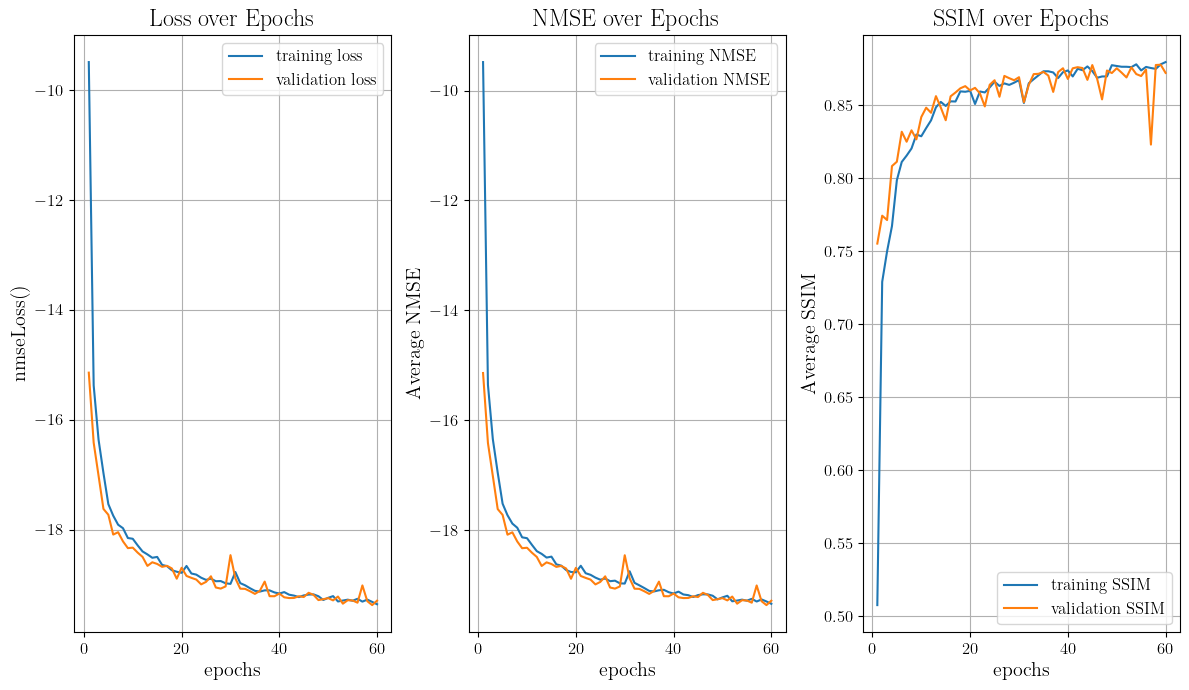

In [27]:
# Run Model with Optimized Parameters

# Train Network ---
sig = 0.1  # Noise std
num_epoch = 60 # Epochs
layer_factor = 24

best_act = nn.ReLU()
best_last_act = None

# print parameters being used: 
print(f"Loss Function: {best_loss_function}"); criterion = best_loss_function
print(f"Activation Function (best previous run): {best_act}"); act = best_act
print(f"Last Layer Activation (best previous run): {best_last_act}"); last_act = best_last_act
print(f"LR Scheduler (optimized): {lr_labels[best_lr_i]}"); lr_i = best_lr_i
print(f"Learning Rate: {best_lr}"); lr=best_lr
print(f"Dropout Rate (optimized): {best_dropout}"); dropout = best_dropout
print(f"Kernel Size: {best_kernel}"); kernel = best_kernel
print(f"Batch Size: {best_batch_size}"); batch_size = best_batch_size

# Model, criterion, and optimizer
train_loader = create_loader(augmented_train_dataset, batch_size) # use larger ausgmented Dataset! 
model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=act, last_act=last_act, kernel=kernel) # Pick a model
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
lr_scheduler = fetch_lr_scheduler(opt, lr_i)

# Let's train the model
storage = train_model(model, opt, lr_scheduler, criterion, train_loader, val_dataset, num_epoch, noise_std=sig)
val_nmse = storage[3]


___
## Run Trivial Net for Report Questions


Epoch 1, Iteration 26, Loss: 0.027287, NMSE: -1.813580, SSIM: 0.088252
Epoch 2, Iteration 26, Loss: 0.018629, NMSE: -4.293046, SSIM: 0.184407
Epoch 3, Iteration 26, Loss: 0.013758, NMSE: -5.972656, SSIM: 0.252961
Epoch 4, Iteration 26, Loss: 0.012991, NMSE: -6.899950, SSIM: 0.292152
Epoch 5, Iteration 26, Loss: 0.009639, NMSE: -7.598845, SSIM: 0.317459
Epoch 6, Iteration 26, Loss: 0.008254, NMSE: -8.268775, SSIM: 0.337497
Epoch 7, Iteration 26, Loss: 0.008009, NMSE: -8.905215, SSIM: 0.353372
Epoch 8, Iteration 26, Loss: 0.006505, NMSE: -9.495229, SSIM: 0.368369
Epoch 9, Iteration 26, Loss: 0.005177, NMSE: -10.037654, SSIM: 0.382483
Epoch 10, Iteration 26, Loss: 0.005037, NMSE: -10.511372, SSIM: 0.394985
Epoch 11, Iteration 26, Loss: 0.004779, NMSE: -10.918901, SSIM: 0.407011
Epoch 12, Iteration 26, Loss: 0.004584, NMSE: -11.243422, SSIM: 0.417044
Epoch 13, Iteration 26, Loss: 0.004096, NMSE: -11.520908, SSIM: 0.426963
Epoch 14, Iteration 26, Loss: 0.004089, NMSE: -11.750591, SSIM: 0.43

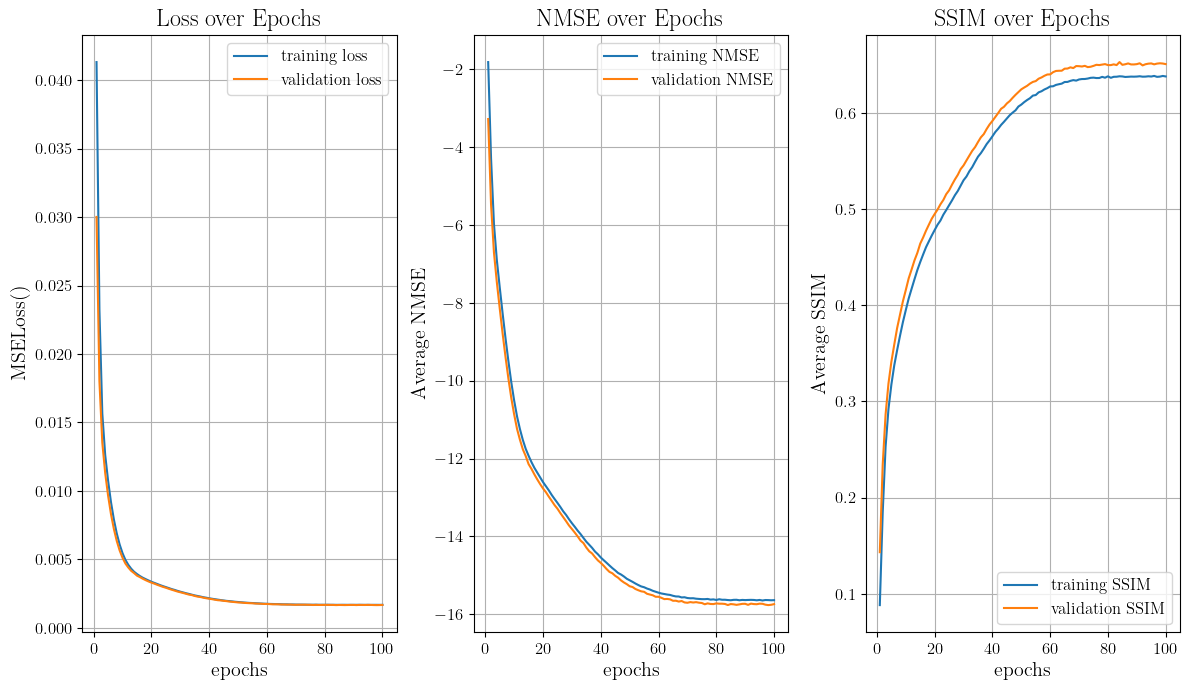

In [28]:
t_batch_size = 2  # Number of complete images in each batch
t_lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
t_num_epoch = 100  # Epochs

# Model, criterion, and optimizer
t_train_loader = create_loader(train_dataset, t_batch_size)
modelTrivial = TrivialNet() # Pick a model
opt = optim.Adam(modelTrivial.parameters(), lr=t_lr) # Pick an optimizer
t_criterion = nn.MSELoss() # Pick a loss function

# Let's train the model
trivialStorage = train_model(modelTrivial, opt, None, t_criterion, t_train_loader, val_dataset, t_num_epoch, noise_std=sig)

___
## Save and/or Load Model

In [29]:
# save parameters
PATH = 'saved_u_net_cnn.pt'
torch.save(model.state_dict(), PATH)


In [30]:
# load parameters from file

# dont want to run with all incase want to train for more epochs after...
"""model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=best_act, last_act=best_last_act, kernel=kernel)
PATH = 'saved_u_net_cnn.pt'
model.load_state_dict(torch.load(PATH)); # learnable parameters
model.eval()"""

"model = UNetAct(dropout=dropout, layer_factor=layer_factor, act=best_act, last_act=best_last_act, kernel=kernel)\nPATH = 'saved_u_net_cnn.pt'\nmodel.load_state_dict(torch.load(PATH)); # learnable parameters\nmodel.eval()"

___
## Visualize Images

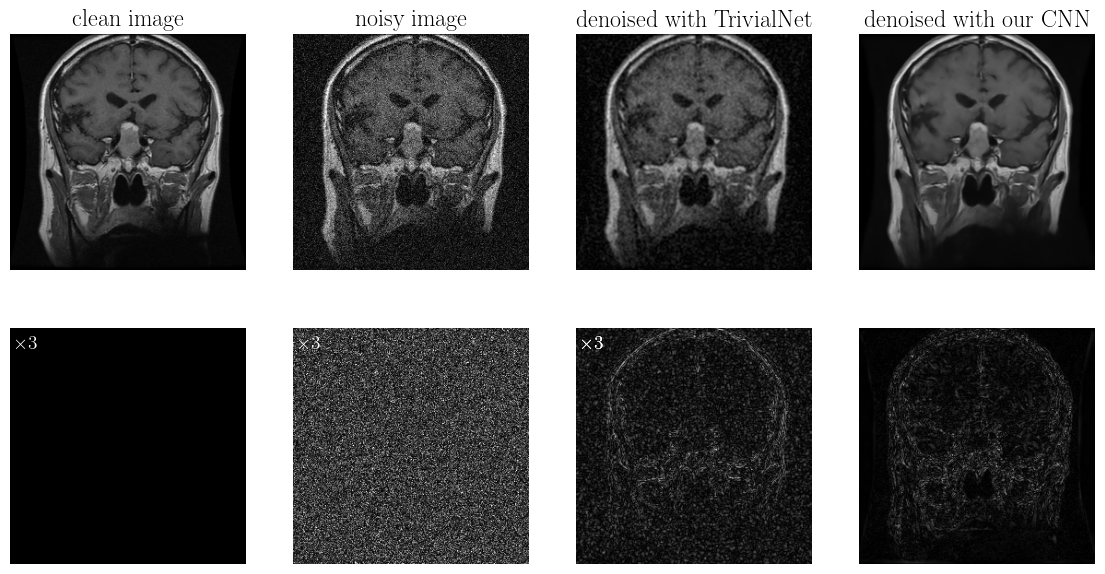

In [31]:
## Modified Code from Dr. Amhad for applying CNN to validation dataset and displaying figure showing the clean, noised, and denoised image
def plot_yhat(modelTrivial, modelOurCNN, image):
    model.eval()
    modelTrivial.eval()

    im_noisy = image + (torch.randn_like(image) * sig) # Add noise to the clean image
    # print(val_noisy.shape)
    im_denoised_trivial = modelTrivial(im_noisy).detach() # Denoise the noisy image using the trained model
    im_denoised_model = modelOurCNN(im_noisy).detach() # Denoise the noisy image using the trained model

    # Your existing code to generate the figure and axes
    fig, ax = plt.subplots(2, 4, figsize=(14, 7))

    # Plot clean image
    ax[0, 0].imshow(np.abs(image).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[0, 0].set_title('clean image')
    ax[0, 0].axis('off')

    # Plot noisy image
    ax[0, 1].imshow(np.abs(im_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[0, 1].set_title('noisy image')
    ax[0, 1].axis('off')

    # Plot denoised image from TrivialNet
    ax[0, 2].imshow(np.abs(im_denoised_trivial).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[0, 2].set_title('denoised with TrivialNet')
    ax[0, 2].axis('off')

    # Plot denoised image from our CNN
    ax[0, 3].imshow(np.abs(im_denoised_model).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[0, 3].set_title('denoised with our CNN')
    ax[0, 3].axis('off')

    # Plot corresponding error images
    ax[1, 0].imshow(3*np.abs(image - image).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[1, 0].axis('off')
    ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

    ax[1, 1].imshow(3*np.abs(image - im_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[1, 1].axis('off')
    ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

    ax[1, 2].imshow(3*np.abs(image - im_denoised_trivial).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[1, 2].axis('off')
    ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

    ax[1, 3].imshow(3*np.abs(image - im_denoised_model).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[1, 3].axis('off')
    ax[1, 3].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

    # plt.tight_layout()
    plt.show()


plot_yhat(modelTrivial, model, test_dataset[0])


___
## Applying Noise and Model to Test Images


In [32]:
# APPLY TO TEST IMAGES 

# initialize tensors to story noisy and denoised images
test_noisy = list()
test_denoised_ourCNN = list()
test_denoised_trivialNet = list()

# for loop to noise and train each image
for image in test_dataset:     
    # create noisy images
    this_noisy = image + (torch.randn_like(image) * sig)
    test_noisy.append(this_noisy) # Add noise to the clean testing set
    test_denoised_ourCNN.append(model(this_noisy).detach()) # Denoise the noisy image using the trained model
    test_denoised_trivialNet.append(modelTrivial(this_noisy).detach()) # Denoise the noisy image using the trained model




___
## Display a figure that shows training loss as a function of epochs as well as training and validation NMSE as a function of epochs; see Demos 16, 17, or 18. The data to create this figure should be generated during the training process. (5%)


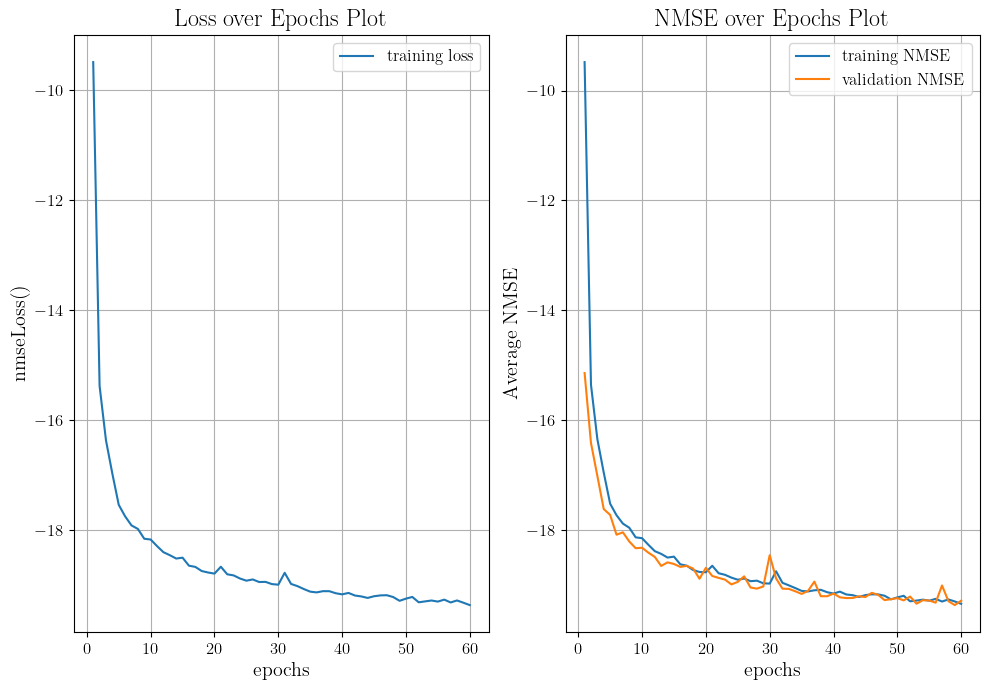

In [33]:
# Display Figure - This is done in the training sections. Can add separate figure here too. 

trainingLoss = storage[0]
trainingNMSE = storage[2]
validationNMSE = storage[3]

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].plot(range(1, num_epoch+1), trainingLoss, label='training loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel(criterion)
ax[0].set_title('Loss over Epochs Plot')
ax[0].grid(True)
ax[0].legend()

# Plotting NMS over epochs
ax[1].plot(range(1, num_epoch+1), trainingNMSE, label='training NMSE')
ax[1].plot(range(1, num_epoch+1), validationNMSE, label='validation NMSE')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Average NMSE')  
ax[1].set_title('NMSE over Epochs Plot')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()



___
##  After training, evaluate the performance of your CNN on training, validation, and test datasets. Your code should display ${\sf{NMSE}}_{\sf tr}$, ${\sf{SSIM}}_{\sf tr}$, ${\sf{NMSE}}_{\sf val}$, ${\sf{SSIM}}_{\sf val}$, ${\sf{NMSE}}_{\sf te}$ and ${\sf{SSIM}}_{\sf te}$. Here, ${\sf NMSE}_{\sf te}$, and ${\sf SSIM}_{\sf te}$ represent NMSE and SSIM values averaged over $m_3$ test images. Likewise, ${\sf NMSE}_{\sf val}$, ${\sf SSIM}_{\sf val}$, ${\sf NMSE}_{\sf tr}$, and ${\sf SSIM}_{\sf tr}$ represents average values from validation and training datasets, respectively. (5%)


In [34]:
# DISPLAY ALL NMSE and SSIM values
# Trivial Net
# training and validation data
nmse_tr = trivialStorage[2][-1]
nmse_val = trivialStorage[3][-1]
ssim_tr = trivialStorage[4][-1]
ssim_val = trivialStorage[5][-1]

# TESTING DATA
# initialize NMSE and SSIM
nmse_sum = 0
ssim_sum = 0

# for loop to go through every image in the set
for i in range(m_te):
    nmse_sum += nmseCalc(test_dataset[i], test_denoised_trivialNet[i]) # use user defined nmse calculation
    ssim_sum += ssimCalc(test_dataset[i], test_denoised_trivialNet[i]) 

# take average
nmse_te = nmse_sum / m_te
ssim_te = ssim_sum / m_te

# print
print(f"TrivialNet:")
print(f"Training Data (last epoch):\n\tAverage NMSE_tr = {nmse_tr:0.4}\n\tAverage SSIM_tr = {ssim_tr:0.4}")
print(f"Validation Data (last epoch):\n\tAverage NMSE_val = {nmse_val:0.4}\n\tAverage SSIM_val = {ssim_val:0.4}")
print(f"Testing Data:\n\tAverage NMSE_te = {nmse_te:0.4}\n\tAverage SSIM_te = {ssim_te:0.4}\n")

# Our CNN
# training and validation data
nmse_tr = trainingNMSE[-1]
nmse_val = validationNMSE[-1]
ssim_tr = storage[4][-1]
ssim_val = storage[5][-1]

# TESTING DATA
# initialize NMSE and SSIM
nmse_sum = 0
ssim_sum = 0

# for loop to go through every image in the set
for i in range(m_te):
    nmse_sum += nmseCalc(test_dataset[i], test_denoised_ourCNN[i]) # use user defined nmse calculation
    ssim_sum += ssimCalc(test_dataset[i], test_denoised_ourCNN[i]) 

# take average
nmse_te = nmse_sum / m_te
ssim_te = ssim_sum / m_te

# print
print(f"OUR CNN:")
print(f"Training Data (last epoch):\n\tAverage NMSE_tr = {nmse_tr:0.4}\n\tAverage SSIM_tr = {ssim_tr:0.4}")
print(f"Validation Data (last epoch):\n\tAverage NMSE_val = {nmse_val:0.4}\n\tAverage SSIM_val = {ssim_val:0.4}")
print(f"Testing Data:\n\tAverage NMSE_te = {nmse_te:0.4}\n\tAverage SSIM_te = {ssim_te:0.4}")


TrivialNet:
Training Data (last epoch):
	Average NMSE_tr = -15.64
	Average SSIM_tr = 0.6378
Validation Data (last epoch):
	Average NMSE_val = -15.74
	Average SSIM_val = 0.6507
Testing Data:
	Average NMSE_te = -15.81
	Average SSIM_te = 0.636

OUR CNN:
Training Data (last epoch):
	Average NMSE_tr = -19.35
	Average SSIM_tr = 0.8796
Validation Data (last epoch):
	Average NMSE_val = -19.29
	Average SSIM_val = 0.8721
Testing Data:
	Average NMSE_te = -19.5
	Average SSIM_te = 0.876


___
## Make sure your denoiser is awesome in terms of NMSE because your earned percentage $= \min[89 - 5({\sf{NMSE}}_{\sf te} + 18.5), 100]$ (65%)

In [35]:
# Use formula to calculate grade based on NMSE and output to screen
# nmse_te = -20.7 required score to get to 100 % - assuming group gets to this, this is min grade
grade = np.min( [(89 - 5*(nmse_te + 18.5) ), 100] )

print(f"With NMSE_te = {nmse_te:0.4}, the (minimum) grade in the NMSE category would be {grade:0.4}%")

With NMSE_te = -19.5, the (minimum) grade in the NMSE category would be 94.0%
